# Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import datetime
from matplotlib import rcParams
from sklearn.preprocessing import LabelEncoder
from scipy import stats
sns.set(style = "white",color_codes = True)

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_transactions = pd.read_csv('../input/final-project-ds/transactions.csv')
df_customer = pd.read_csv('../input/final-project-ds/customer.csv')

In [4]:
df_transaction = pd.read_csv('../input/final-project-ds/transactions.csv')

# Feature Engineering

In [5]:
df_transactions['created_at'] = pd.to_datetime(df_transactions['created_at'], infer_datetime_format=True, utc = True)
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'], infer_datetime_format=True, utc = True)
df_transactions = df_transactions.loc[(df_transactions["created_at"] >= "2021-11-01") & (df_transactions["created_at"] <= "2022-04-30")].copy()
df_transaction = df_transaction.loc[(df_transaction["created_at"] >= "2021-11-01") & (df_transactions["created_at"] <= "2022-04-30")].copy()

In [6]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160466 entries, 27 to 852581
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   created_at              160466 non-null  datetime64[ns, UTC]
 1   customer_id             160466 non-null  int64              
 2   booking_id              160466 non-null  object             
 3   session_id              160466 non-null  object             
 4   product_metadata        160466 non-null  object             
 5   payment_method          160466 non-null  object             
 6   payment_status          160466 non-null  object             
 7   promo_amount            160466 non-null  int64              
 8   promo_code              53401 non-null   object             
 9   shipment_fee            160466 non-null  int64              
 10  shipment_date_limit     160466 non-null  object             
 11  shipment_location_lat   1

In [7]:
df_transactions['customer_id'].nunique()

33147

In [8]:
df_transactions['product_metadata'] = df_transactions['product_metadata'].replace({'\[{':'','\}]':'','\'':'','\:':',','\{':'','\},':';'}, regex=True)

In [9]:
df=df_transactions[['product_metadata']]

In [10]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [11]:
df_transactions=explode(df_transactions.assign(product_metadata=df_transactions['product_metadata'].str.split(';')), 'product_metadata')

In [12]:
df_transactions[['id_n','product_id','q_n','quantity','p_n','item_price']] = df_transactions.product_metadata.str.split(",", expand=True)
df_transactions=df_transactions.drop(columns = ['id_n', 'q_n', 'p_n'])
df_transactions.head(20)

,booking_id,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,session_id,shipment_date_limit,shipment_fee,shipment_location_lat,shipment_location_long,total_amount,product_metadata,product_id,quantity,item_price
0,e319fd63-6af2-4103-bf76-4b84658ac92f,2021-12-03 11:55:49.365620,4774,Credit Card,Success,3830,AZ2022,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,2021-12-06T06:33:52.568869Z,10000,-2.452739,101.284423,488031,"product_id, 18477, quantity, 1, item_price, 48...",18477,1,481861
1,0d1342a0-bac8-4837-bea6-4196033422a5,2022-01-19 11:25:46.365620,4774,Credit Card,Success,0,NaN,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,2022-01-21T19:43:30.621980Z,5000,-3.602334,120.363824,1078709,"product_id, 33212, quantity, 3, item_price, 35...",33212,3,357903
2,e9597c94-dd17-4a93-81d9-aae586182d87,2022-03-07 10:53:30.365620,4774,Debit Card,Success,7255,AZ2022,514d9158-5020-4dd9-8ca0-22097c600b78,2022-03-10T13:56:47.688241Z,10000,-7.816892,110.255406,311231,"product_id, 21995, quantity, 1, item_price, 30...",21995,1,308486
3,e82a1b9f-7a30-431b-af7d-8108f6aca0c9,2022-04-23 11:43:52.365620,4774,Credit Card,Success,7079,LIBURDONG,7e644152-6798-4511-8c27-0648ebff6e17,2022-04-26T01:42:33.649906Z,10000,-3.267492,104.532408,117133,"product_id, 51055, quantity, 1, item_price, 11...",51055,1,114212
4,b11a1f9b-8416-4cb2-89b4-b3aeb75e5bbd,2021-11-10 18:36:01.162570,58191,OVO,Success,5521,AZ2022,5f42918e-b3a7-432c-b31b-01708be78a63,2021-11-15T19:22:15.686120Z,10000,-0.187164,99.944189,146737,"product_id, 27034, quantity, 1, item_price, 14...",27034,1,142258
5,78bac6bc-ca99-403c-90aa-98eb0a28c421,2021-11-25 18:52:12.162570,58191,OVO,Success,0,NaN,eac9444c-0a9a-4c88-bd42-6e8c0559de94,2021-11-28T18:41:13.923937Z,0,-8.328679,118.773797,1379692,"product_id, 20503, quantity, 1, item_price, 60...",20503,1,608531
6,78bac6bc-ca99-403c-90aa-98eb0a28c421,2021-11-25 18:52:12.162570,58191,OVO,Success,0,NaN,eac9444c-0a9a-4c88-bd42-6e8c0559de94,2021-11-28T18:41:13.923937Z,0,-8.328679,118.773797,1379692,"product_id, 7418, quantity, 1, item_price, 20...",7418,1,206569
7,78bac6bc-ca99-403c-90aa-98eb0a28c421,2021-11-25 18:52:12.162570,58191,OVO,Success,0,NaN,eac9444c-0a9a-4c88-bd42-6e8c0559de94,2021-11-28T18:41:13.923937Z,0,-8.328679,118.773797,1379692,"product_id, 21950, quantity, 1, item_price, 1...",21950,1,175840
8,78bac6bc-ca99-403c-90aa-98eb0a28c421,2021-11-25 18:52:12.162570,58191,OVO,Success,0,NaN,eac9444c-0a9a-4c88-bd42-6e8c0559de94,2021-11-28T18:41:13.923937Z,0,-8.328679,118.773797,1379692,"product_id, 3062, quantity, 1, item_price, 21...",3062,1,212784
9,78bac6bc-ca99-403c-90aa-98eb0a28c421,2021-11-25 18:52:12.162570,58191,OVO,Success,0,NaN,eac9444c-0a9a-4c88-bd42-6e8c0559de94,2021-11-28T18:41:13.923937Z,0,-8.328679,118.773797,1379692,"product_id, 19442, quantity, 1, item_price, 1...",19442,1,175968


In [13]:
df = df_customer.merge(df_transaction, on='customer_id', how='right')
df.head(2)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-12-03 11:55:49.365620+00:00,e319fd63-6af2-4103-bf76-4b84658ac92f,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,"[{'product_id': 18477, 'quantity': 1, 'item_pr...",Credit Card,Success,3830,AZ2022,10000,2021-12-06T06:33:52.568869Z,-2.452739,101.284423,488031
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-01-19 11:25:46.365620+00:00,0d1342a0-bac8-4837-bea6-4196033422a5,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,"[{'product_id': 33212, 'quantity': 3, 'item_pr...",Credit Card,Success,0,NaN,5000,2022-01-21T19:43:30.621980Z,-3.602334,120.363824,1078709


In [14]:
df_ct = df[['customer_id','first_join_date','created_at']]
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160466 entries, 0 to 160465
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   customer_id      160466 non-null  int64              
 1   first_join_date  160466 non-null  object             
 2   created_at       160466 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 4.9+ MB


In [15]:
df_ct = df_ct.sort_values('created_at').groupby('customer_id').tail(1)

In [16]:
# # One Hot Encoding Kolom payment_method
# df_m = pd.concat([df_m, pd.get_dummies(df_m.payment_method, prefix='payment_method')], axis=1)
# df_m

In [17]:
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-12-03 11:55:49.365620+00:00,e319fd63-6af2-4103-bf76-4b84658ac92f,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,"[{'product_id': 18477, 'quantity': 1, 'item_pr...",Credit Card,Success,3830,AZ2022,10000,2021-12-06T06:33:52.568869Z,-2.452739,101.284423,488031
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-01-19 11:25:46.365620+00:00,0d1342a0-bac8-4837-bea6-4196033422a5,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,"[{'product_id': 33212, 'quantity': 3, 'item_pr...",Credit Card,Success,0,NaN,5000,2022-01-21T19:43:30.621980Z,-3.602334,120.363824,1078709
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-03-07 10:53:30.365620+00:00,e9597c94-dd17-4a93-81d9-aae586182d87,514d9158-5020-4dd9-8ca0-22097c600b78,"[{'product_id': 21995, 'quantity': 1, 'item_pr...",Debit Card,Success,7255,AZ2022,10000,2022-03-10T13:56:47.688241Z,-7.816892,110.255406,311231
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-04-23 11:43:52.365620+00:00,e82a1b9f-7a30-431b-af7d-8108f6aca0c9,7e644152-6798-4511-8c27-0648ebff6e17,"[{'product_id': 51055, 'quantity': 1, 'item_pr...",Credit Card,Success,7079,LIBURDONG,10000,2022-04-26T01:42:33.649906Z,-3.267492,104.532408,117133
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-11-10 18:36:01.162570+00:00,b11a1f9b-8416-4cb2-89b4-b3aeb75e5bbd,5f42918e-b3a7-432c-b31b-01708be78a63,"[{'product_id': 27034, 'quantity': 1, 'item_pr...",OVO,Success,5521,AZ2022,10000,2021-11-15T19:22:15.686120Z,-0.187164,99.944189,146737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160461,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2022-01-10 13:51:41.359304+00:00,bee016e5-7dd9-4689-bad0-3dfdaf09ba99,b4a2ca36-4250-47cb-b799-89db41316b1b,"[{'product_id': 54582, 'quantity': 1, 'item_pr...",OVO,Success,0,NaN,10000,2022-01-14T02:40:21.501322Z,-4.651293,119.748660,196191
160462,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca0072,a6b1f57d_4085_4b00_97a0_50f252ca0072@zakyfound...,M,1987-08-02,Android,56b42fbd-5041-485e-8c9e-fc3c8145e96d,Android 6.0.1,-2.173010,119.336234,Sulawesi Barat,Indonesia,2021-05-25,2021-12-27 20:11:09.098790+00:00,7a6ecaf3-316d-40b2-b366-8f670d669c30,8d9f019f-600c-439e-b302-0779540e0561,"[{'product_id': 19536, 'quantity': 1, 'item_pr...",OVO,Success,2603,XX2022,25000,2022-01-01T20:00:54.420462Z,0.388382,110.951356,340924
160463,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca0072,a6b1f57d_4085_4b00_97a0

In [18]:
# One Hot Encoding Kolom payment_method
df = pd.concat([df, pd.get_dummies(df.payment_method, prefix='payment_method')], axis=1)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-12-03 11:55:49.365620+00:00,e319fd63-6af2-4103-bf76-4b84658ac92f,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,"[{'product_id': 18477, 'quantity': 1, 'item_pr...",Credit Card,Success,3830,AZ2022,10000,2021-12-06T06:33:52.568869Z,-2.452739,101.284423,488031,1,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-01-19 11:25:46.365620+00:00,0d1342a0-bac8-4837-bea6-4196033422a5,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,"[{'product_id': 33212, 'quantity': 3, 'item_pr...",Credit Card,Success,0,NaN,5000,2022-01-21T19:43:30.621980Z,-3.602334,120.363824,1078709,1,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-03-07 10:53:30.365620+00:00,e9597c94-dd17-4a93-81d9-aae586182d87,514d9158-5020-4dd9-8ca0-22097c600b78,"[{'product_id': 21995, 'quantity': 1, 'item_pr...",Debit Card,Success,7255,AZ2022,10000,2022-03-10T13:56:47.688241Z,-7.816892,110.255406,311231,0,1,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-04-23 11:43:52.365620+00:00,e82a1b9f-7a30-431b-af7d-8108f6aca0c9,7e644152-6798-4511-8c27-0648ebff6e17,"[{'product_id': 51055, 'quantity': 1, 'item_pr...",Credit Card,Success,7079,LIBURDONG,10000,2022-04-26T01:42:33.649906Z,-3.267492,104.532408,117133,1,0,0,0,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-11-10 18:36:01.162570+00:00,b11a1f9b-8416-4cb2-89b4-b3aeb75e5bbd,5f42918e-b3a7-432c-b31b-01708be78a63,"[{'product_id': 27034, 'quantity': 1, 'item_pr...",OVO,Success,5521,AZ2022,10000,2021-11-15T19:22:15.686120Z,-0.187164,99.944189,146737,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160461,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2022-01-10 13:51:41.359304+00:00,bee016e5-7dd9-4689-bad0-3dfdaf09ba99,b4a2ca36-4250-47cb-b799-89db41316b1b,"[{'product_id': 54582, 'quantity': 1, 'item_pr...",OVO,Success,0,NaN,10000,2022-01-14T02:40:21.501322Z,-4.651293,119.748660,196191,0,0,0,0,1
160462,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca0072,a6b1f57d_4085_4b00_97a0_50f252ca0072@zakyfound...,M,1987-08-02,Android,56b42fbd-5041-485e-8c9e-fc3c8145e96d,Android 6.0.1,-2.173010,119.336234,Sulawesi Barat,Indonesia,2021-05-25,2021-12-27 20:11:09.098790+00:00,7a6ecaf3-316d-40b2-b366-8f670d669c30,8d9f019f-600c-439e-b302-0779540e0561,"[{'product_id': 19536, 'q

In [19]:
df = pd.concat([df, pd.get_dummies(df.promo_code, prefix='promo_code')], axis=1)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO,promo_code_AZ2022,promo_code_BUYMORE,promo_code_LIBURDONG,promo_code_SC2022,promo_code_STARTUP,promo_code_WEEKENDMANTAP,promo_code_WEEKENDSERU,promo_code_XX2022
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-12-03 11:55:49.365620+00:00,e319fd63-6af2-4103-bf76-4b84658ac92f,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,"[{'product_id': 18477, 'quantity': 1, 'item_pr...",Credit Card,Success,3830,AZ2022,10000,2021-12-06T06:33:52.568869Z,-2.452739,101.284423,488031,1,0,0,0,0,1,0,0,0,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-01-19 11:25:46.365620+00:00,0d1342a0-bac8-4837-bea6-4196033422a5,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,"[{'product_id': 33212, 'quantity': 3, 'item_pr...",Credit Card,Success,0,NaN,5000,2022-01-21T19:43:30.621980Z,-3.602334,120.363824,1078709,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-03-07 10:53:30.365620+00:00,e9597c94-dd17-4a93-81d9-aae586182d87,514d9158-5020-4dd9-8ca0-22097c600b78,"[{'product_id': 21995, 'quantity': 1, 'item_pr...",Debit Card,Success,7255,AZ2022,10000,2022-03-10T13:56:47.688241Z,-7.816892,110.255406,311231,0,1,0,0,0,1,0,0,0,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-04-23 11:43:52.365620+00:00,e82a1b9f-7a30-431b-af7d-8108f6aca0c9,7e644152-6798-4511-8c27-0648ebff6e17,"[{'product_id': 51055, 'quantity': 1, 'item_pr...",Credit Card,Success,7079,LIBURDONG,10000,2022-04-26T01:42:33.649906Z,-3.267492,104.532408,117133,1,0,0,0,0,0,0,1,0,0,0,0,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-11-10 18:36:01.162570+00:00,b11a1f9b-8416-4cb2-89b4-b3aeb75e5bbd,5f42918e-b3a7-432c-b31b-01708be78a63,"[{'product_id': 27034, 'quantity': 1, 'item_pr...",OVO,Success,5521,AZ2022,10000,2021-11-15T19:22:15.686120Z,-0.187164,99.944189,146737,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160461,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2022-01-10 13:51:41.359304+00:00,bee016e5-7dd9-4689-bad0-3dfdaf09ba99,b4a2ca36-4250-47cb-b799-89db41316b1b,"[{'product_id': 54582, 'quantity': 1, 'item_pr...",OVO,Success,0,NaN,10000,2022-01-14T02:40:21.501322Z,-4.651293,119.748660,196191,0,0,0,0,1,0,0,0,0,0,0,0,0
160462,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca0072,a6b1f57d_4085_4b00_97a0

In [20]:
# Label Encoding Kolom payment_status
payment_status = {'Success': 1, 'Failed': 0}
df['payment_status'] = df['payment_status'].map(payment_status)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO,promo_code_AZ2022,promo_code_BUYMORE,promo_code_LIBURDONG,promo_code_SC2022,promo_code_STARTUP,promo_code_WEEKENDMANTAP,promo_code_WEEKENDSERU,promo_code_XX2022
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-12-03 11:55:49.365620+00:00,e319fd63-6af2-4103-bf76-4b84658ac92f,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,"[{'product_id': 18477, 'quantity': 1, 'item_pr...",Credit Card,1,3830,AZ2022,10000,2021-12-06T06:33:52.568869Z,-2.452739,101.284423,488031,1,0,0,0,0,1,0,0,0,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-01-19 11:25:46.365620+00:00,0d1342a0-bac8-4837-bea6-4196033422a5,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,"[{'product_id': 33212, 'quantity': 3, 'item_pr...",Credit Card,1,0,NaN,5000,2022-01-21T19:43:30.621980Z,-3.602334,120.363824,1078709,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-03-07 10:53:30.365620+00:00,e9597c94-dd17-4a93-81d9-aae586182d87,514d9158-5020-4dd9-8ca0-22097c600b78,"[{'product_id': 21995, 'quantity': 1, 'item_pr...",Debit Card,1,7255,AZ2022,10000,2022-03-10T13:56:47.688241Z,-7.816892,110.255406,311231,0,1,0,0,0,1,0,0,0,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-04-23 11:43:52.365620+00:00,e82a1b9f-7a30-431b-af7d-8108f6aca0c9,7e644152-6798-4511-8c27-0648ebff6e17,"[{'product_id': 51055, 'quantity': 1, 'item_pr...",Credit Card,1,7079,LIBURDONG,10000,2022-04-26T01:42:33.649906Z,-3.267492,104.532408,117133,1,0,0,0,0,0,0,1,0,0,0,0,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-11-10 18:36:01.162570+00:00,b11a1f9b-8416-4cb2-89b4-b3aeb75e5bbd,5f42918e-b3a7-432c-b31b-01708be78a63,"[{'product_id': 27034, 'quantity': 1, 'item_pr...",OVO,1,5521,AZ2022,10000,2021-11-15T19:22:15.686120Z,-0.187164,99.944189,146737,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160461,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2022-01-10 13:51:41.359304+00:00,bee016e5-7dd9-4689-bad0-3dfdaf09ba99,b4a2ca36-4250-47cb-b799-89db41316b1b,"[{'product_id': 54582, 'quantity': 1, 'item_pr...",OVO,1,0,NaN,10000,2022-01-14T02:40:21.501322Z,-4.651293,119.748660,196191,0,0,0,0,1,0,0,0,0,0,0,0,0
160462,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca0072,a6b1f57d_4085_4b00_97a0_50f252ca0072@zakyfound...,M,1987-08

In [21]:
df_PST = df[['customer_id','payment_status']]
df_PST['payment_status'] = df_PST.groupby('customer_id')['payment_status'].transform('mean')
df_PST=df_PST.drop_duplicates('customer_id')
df_PST

,customer_id,payment_status
0,4774,1.000000
4,58191,0.916667
16,76966,1.000000
28,56690,1.000000
30,13813,1.000000
...,...,...
160460,32621,1.000000
160461,64772,1.000000
160462,37287,1.000000
160464,34829,1.000000


In [22]:
df_PA = df[['customer_id','promo_amount']]
df_PA['promo_amount'] = df_PA.groupby('customer_id')['promo_amount'].transform('mean')
df_PA=df_PA.drop_duplicates('customer_id')
df_PA

,customer_id,promo_amount
0,4774,4541.000000
4,58191,1690.666667
16,76966,2756.166667
28,56690,2398.500000
30,13813,2073.000000
...,...,...
160460,32621,9701.000000
160461,64772,0.000000
160462,37287,3746.500000
160464,34829,5010.000000


In [23]:
df_PMC = df[['customer_id','payment_method_Credit Card']]
df_PMC['payment_method_Credit_Card'] = df_PMC.groupby('customer_id')['payment_method_Credit Card'].transform('sum')
df_PMC=df_PMC.drop_duplicates('customer_id')
df_PMC

,customer_id,payment_method_Credit Card,payment_method_Credit_Card
0,4774,1,3
4,58191,0,0
16,76966,1,10
28,56690,0,0
30,13813,0,0
...,...,...,...
160460,32621,0,0
160461,64772,0,0
160462,37287,0,0
160464,34829,0,0


In [24]:
# pmdc = payment methods debit card
df_PMDC = df[['customer_id','payment_method_Debit Card']]
df_PMDC['payment_method_Debit_Card'] = df_PMDC.groupby('customer_id')['payment_method_Debit Card'].transform('sum')
df_PMDC=df_PMDC.drop_duplicates('customer_id')
df_PMDC

,customer_id,payment_method_Debit Card,payment_method_Debit_Card
0,4774,0,1
4,58191,0,0
16,76966,0,2
28,56690,1,1
30,13813,0,0
...,...,...,...
160460,32621,0,0
160461,64772,0,0
160462,37287,0,0
160464,34829,0,0


In [25]:
# payment methods gopay
df_PMG = df[['customer_id','payment_method_Gopay']]
df_PMG['payment_method_Gopay'] = df_PMG.groupby('customer_id')['payment_method_Gopay'].transform('sum')
df_PMG=df_PMG.drop_duplicates('customer_id')
df_PMG

,customer_id,payment_method_Gopay
0,4774,0
4,58191,1
16,76966,0
28,56690,0
30,13813,2
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,0


In [26]:
# payment methods linkaja
df_PMLA = df[['customer_id','payment_method_LinkAja']]
df_PMLA['payment_method_LinkAja'] = df_PMLA.groupby('customer_id')['payment_method_LinkAja'].transform('sum')
df_PMLA=df_PMLA.drop_duplicates('customer_id')
df_PMLA

,customer_id,payment_method_LinkAja
0,4774,0
4,58191,0
16,76966,0
28,56690,0
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,0


In [27]:
# payment methods ovo
df_PMO = df[['customer_id','payment_method_OVO']]
df_PMO['payment_method_OVO'] = df_PMO.groupby('customer_id')['payment_method_OVO'].transform('sum')
df_PMO=df_PMO.drop_duplicates('customer_id')
df_PMO

,customer_id,payment_method_OVO
0,4774,0
4,58191,11
16,76966,0
28,56690,1
30,13813,0
...,...,...
160460,32621,1
160461,64772,1
160462,37287,2
160464,34829,1


In [28]:
df_PCAZ = df[['customer_id','promo_code_AZ2022']]
df_PCAZ['promo_code_AZ2022'] = df_PCAZ.groupby('customer_id')['promo_code_AZ2022'].transform('sum')
df_PCAZ=df_PCAZ.drop_duplicates('customer_id')
df_PCAZ

,customer_id,promo_code_AZ2022
0,4774,2
4,58191,2
16,76966,0
28,56690,0
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,1


In [29]:
df_PCBY = df[['customer_id','promo_code_BUYMORE']]
df_PCBY['promo_code_BUYMORE'] = df_PCBY.groupby('customer_id')['promo_code_BUYMORE'].transform('sum')
df_PCBY=df_PCBY.drop_duplicates('customer_id')
df_PCBY

,customer_id,promo_code_BUYMORE
0,4774,0
4,58191,0
16,76966,0
28,56690,0
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,1
160464,34829,0


In [30]:
df_PCLD = df[['customer_id','promo_code_LIBURDONG']]
df_PCLD['promo_code_LIBURDONG'] = df_PCLD.groupby('customer_id')['promo_code_LIBURDONG'].transform('sum')
df_PCLD=df_PCLD.drop_duplicates('customer_id')
df_PCLD

,customer_id,promo_code_LIBURDONG
0,4774,1
4,58191,0
16,76966,1
28,56690,0
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,0


In [31]:
df_PCSC = df[['customer_id','promo_code_SC2022']]
df_PCSC['promo_code_SC2022'] = df_PCSC.groupby('customer_id')['promo_code_SC2022'].transform('sum')
df_PCSC=df_PCSC.drop_duplicates('customer_id')
df_PCSC

,customer_id,promo_code_SC2022
0,4774,0
4,58191,0
16,76966,0
28,56690,0
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,0


In [32]:
df_PCST = df[['customer_id','promo_code_STARTUP']]
df_PCST['promo_code_STARTUP'] = df_PCST.groupby('customer_id')['promo_code_STARTUP'].transform('sum')
df_PCST=df_PCST.drop_duplicates('customer_id')
df_PCST

,customer_id,promo_code_STARTUP
0,4774,0
4,58191,0
16,76966,0
28,56690,0
30,13813,1
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,0


In [33]:
df_PCWM = df[['customer_id','promo_code_WEEKENDMANTAP']]
df_PCWM['promo_code_WEEKENDMANTAP'] = df_PCWM.groupby('customer_id')['promo_code_WEEKENDMANTAP'].transform('sum')
df_PCWM=df_PCWM.drop_duplicates('customer_id')
df_PCWM 

,customer_id,promo_code_WEEKENDMANTAP
0,4774,0
4,58191,1
16,76966,2
28,56690,0
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,0
160464,34829,0


In [34]:
df_PCWS = df[['customer_id','promo_code_WEEKENDSERU']]
df_PCWS['promo_code_WEEKENDSERU'] = df_PCWS.groupby('customer_id')['promo_code_WEEKENDSERU'].transform('sum')
df_PCWS=df_PCWS.drop_duplicates('customer_id')
df_PCWS 

,customer_id,promo_code_WEEKENDSERU
0,4774,0
4,58191,1
16,76966,4
28,56690,0
30,13813,0
...,...,...
160460,32621,1
160461,64772,0
160462,37287,0
160464,34829,0


In [35]:
df_PCXX = df[['customer_id','promo_code_XX2022']]
df_PCXX['promo_code_XX2022'] = df_PCXX.groupby('customer_id')['promo_code_XX2022'].transform('sum')
df_PCXX=df_PCXX.drop_duplicates('customer_id')
df_PCXX 

,customer_id,promo_code_XX2022
0,4774,0
4,58191,1
16,76966,0
28,56690,1
30,13813,0
...,...,...
160460,32621,0
160461,64772,0
160462,37287,1
160464,34829,0


In [36]:
df_pm = df_PCXX.merge(df_PCWS, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCWM, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCST, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCSC, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCLD, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCBY, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCAZ, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMO, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMLA, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMG, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMDC, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMC, on='customer_id', how='left')
df_pm = df_pm.merge(df_PA, on='customer_id', how='left')
df_pm = df_pm.merge(df_PST, on='customer_id', how='left')

In [37]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 0 to 33146
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 33147 non-null  int64  
 1   promo_code_XX2022           33147 non-null  uint8  
 2   promo_code_WEEKENDSERU      33147 non-null  uint8  
 3   promo_code_WEEKENDMANTAP    33147 non-null  uint8  
 4   promo_code_STARTUP          33147 non-null  uint8  
 5   promo_code_SC2022           33147 non-null  uint8  
 6   promo_code_LIBURDONG        33147 non-null  uint8  
 7   promo_code_BUYMORE          33147 non-null  uint8  
 8   promo_code_AZ2022           33147 non-null  uint8  
 9   payment_method_OVO          33147 non-null  uint8  
 10  payment_method_LinkAja      33147 non-null  uint8  
 11  payment_method_Gopay        33147 non-null  uint8  
 12  payment_method_Debit Card   33147 non-null  uint8  
 13  payment_method_Debit_Card   331

In [38]:
df_pm.isnull().sum()

customer_id                   0
promo_code_XX2022             0
promo_code_WEEKENDSERU        0
promo_code_WEEKENDMANTAP      0
promo_code_STARTUP            0
promo_code_SC2022             0
promo_code_LIBURDONG          0
promo_code_BUYMORE            0
promo_code_AZ2022             0
payment_method_OVO            0
payment_method_LinkAja        0
payment_method_Gopay          0
payment_method_Debit Card     0
payment_method_Debit_Card     0
payment_method_Credit Card    0
payment_method_Credit_Card    0
promo_amount                  0
payment_status                0
dtype: int64

In [39]:
df_pm

,customer_id,promo_code_XX2022,promo_code_WEEKENDSERU,promo_code_WEEKENDMANTAP,promo_code_STARTUP,promo_code_SC2022,promo_code_LIBURDONG,promo_code_BUYMORE,promo_code_AZ2022,payment_method_OVO,payment_method_LinkAja,payment_method_Gopay,payment_method_Debit Card,payment_method_Debit_Card,payment_method_Credit Card,payment_method_Credit_Card,promo_amount,payment_status
0,4774,0,0,0,0,0,1,0,2,0,0,0,0,1,1,3,4541.000000,1.000000
1,58191,1,1,1,0,0,0,0,2,11,0,1,0,0,0,0,1690.666667,0.916667
2,76966,0,4,2,0,0,1,0,0,0,0,0,0,2,1,10,2756.166667,1.000000
3,56690,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2398.500000,1.000000
4,13813,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,2073.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33142,32621,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,9701.000000,1.000000
33143,64772,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,1.000000
33144,37287,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,3746.500000,1.000000
33145,34829,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,5010.000000,1.000000


In [40]:
df_pm.promo_code_XX2022.fillna(0, inplace = True)
df_pm.promo_code_WEEKENDSERU.fillna(0, inplace = True)
df_pm.promo_code_WEEKENDMANTAP.fillna(0, inplace = True)
df_pm.promo_code_STARTUP.fillna(0, inplace = True)
df_pm.promo_code_SC2022.fillna(0, inplace = True)
df_pm.promo_code_LIBURDONG.fillna(0, inplace = True)
df_pm.promo_code_BUYMORE.fillna(0, inplace = True)
df_pm.promo_code_AZ2022.fillna(0, inplace = True)
df_pm.payment_method_OVO.fillna(0, inplace = True)
df_pm.payment_method_LinkAja.fillna(0, inplace = True)
df_pm.payment_method_Gopay.fillna(0, inplace = True)
df_pm.payment_method_Debit_Card.fillna(0, inplace = True)
df_pm.payment_method_Credit_Card.fillna(0, inplace = True)
df_pm.promo_amount.fillna(0, inplace = True)
df_pm.payment_status.fillna(0, inplace = True)

In [41]:
df_pm.payment_status.fillna(0, inplace = True)

In [42]:
df_pm['promo_amount'].fillna(0, inplace = True)

In [43]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 0 to 33146
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 33147 non-null  int64  
 1   promo_code_XX2022           33147 non-null  uint8  
 2   promo_code_WEEKENDSERU      33147 non-null  uint8  
 3   promo_code_WEEKENDMANTAP    33147 non-null  uint8  
 4   promo_code_STARTUP          33147 non-null  uint8  
 5   promo_code_SC2022           33147 non-null  uint8  
 6   promo_code_LIBURDONG        33147 non-null  uint8  
 7   promo_code_BUYMORE          33147 non-null  uint8  
 8   promo_code_AZ2022           33147 non-null  uint8  
 9   payment_method_OVO          33147 non-null  uint8  
 10  payment_method_LinkAja      33147 non-null  uint8  
 11  payment_method_Gopay        33147 non-null  uint8  
 12  payment_method_Debit Card   33147 non-null  uint8  
 13  payment_method_Debit_Card   331

In [44]:
#yang bagus cuma promo amount sama payment status, jadi yg dipake itu doang
df_pm = df_pm[['customer_id','promo_amount','payment_status']]

In [45]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 0 to 33146
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     33147 non-null  int64  
 1   promo_amount    33147 non-null  float64
 2   payment_status  33147 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.0 MB


In [46]:
# error

In [47]:
# df_m

In [48]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 84919 to 118123
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      33147 non-null  int64              
 1   first_join_date  33147 non-null  object             
 2   created_at       33147 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 1.0+ MB


In [49]:
# df_ct['created_at']=df_ct['created_at'].fillna(df_ct['first_join_date'])

In [50]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 84919 to 118123
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      33147 non-null  int64              
 1   first_join_date  33147 non-null  object             
 2   created_at       33147 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 1.0+ MB


In [51]:
df_ct['first_join_date'] = pd.to_datetime(df_ct['first_join_date'], infer_datetime_format=True, utc = True)

In [52]:
df_ct['created_at']=pd.to_datetime(df_ct['created_at'], format = '%Y-%m-%d ',utc=True)

In [53]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 84919 to 118123
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      33147 non-null  int64              
 1   first_join_date  33147 non-null  datetime64[ns, UTC]
 2   created_at       33147 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1)
memory usage: 1.0 MB


In [54]:
#durasi bertahan = jarak first join date ke terakhir beli
df_ct['durasi_bertahan'] = (df_ct['created_at'] - df_ct['first_join_date']).dt.days

In [55]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 84919 to 118123
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      33147 non-null  int64              
 1   first_join_date  33147 non-null  datetime64[ns, UTC]
 2   created_at       33147 non-null  datetime64[ns, UTC]
 3   durasi_bertahan  33147 non-null  int64              
dtypes: datetime64[ns, UTC](2), int64(2)
memory usage: 1.3 MB


In [56]:
df_ct=df_ct.drop(columns =['first_join_date','created_at'])

In [57]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 84919 to 118123
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   customer_id      33147 non-null  int64
 1   durasi_bertahan  33147 non-null  int64
dtypes: int64(2)
memory usage: 776.9 KB


In [58]:
df_customer['first_join_date'] = pd.to_datetime(df_customer['first_join_date'], infer_datetime_format=True)
curr_time = pd.to_datetime("now")
df_customer['joins_duration']=(curr_time-df_customer['first_join_date']).dt.days
df_customer.head(2)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,joins_duration
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21,1235
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16,1970


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160466 entries, 0 to 160465
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   customer_id                 160466 non-null  int64              
 1   first_name                  160466 non-null  object             
 2   last_name                   160466 non-null  object             
 3   username                    160466 non-null  object             
 4   email                       160466 non-null  object             
 5   gender                      160466 non-null  object             
 6   birthdate                   160466 non-null  object             
 7   device_type                 160466 non-null  object             
 8   device_id                   160466 non-null  object             
 9   device_version              160466 non-null  object             
 10  home_location_lat           160466 non-null 

In [60]:
# recency ->  transactions.created_at
# frequency -> count(transactions.created_at) group by cust_id
# monetary -> sum(transactions.total_amount) group by cust_id
# total_items -> sum(transactions.quantity)
# total_price -> (item_price*quantity)
# total_freight_value -> shipment_fee
# total_order_value -> total_price + shipment_fee

df.frequency.isnull().sum()

In [61]:
# df["quantity"] = pd.to_numeric(df["quantity"])

In [62]:
# # total_items -> sum(transactions.quantity)
# df_ti = df[['customer_id','quantity']]
# df_ti['quantity'] = df_ti.groupby('customer_id')['quantity'].transform('sum')
# df_ti=df_ti.drop_duplicates('customer_id')
# df_ti

In [63]:
# df["item_price"] = pd.to_numeric(df["item_price"])
# df["quantity"] = pd.to_numeric(df["quantity"])

In [64]:
# df_tp = df[['customer_id','item_price']]

In [65]:
# df_tp['total_price'] = df_tp.groupby('customer_id')['item_price'].transform('sum')
# df_tp = df_tp.drop_duplicates('customer_id')
# df_tp=df_tp.drop(columns = ['item_price'])
# df_tp

In [66]:
# df_tp

In [67]:
# total_order_value -> total_price + shipment_fee
df_tov = df[['customer_id','total_amount','promo_amount']]
df_tov['total_order_value'] = df_tov['total_amount'] - df_tov['promo_amount']
df_tov['total_order_value'] = df_tov.groupby('customer_id')['total_order_value'].transform('sum')
df_tov=df_tov.drop_duplicates('customer_id')
df_tov=df_tov.drop(columns = ['total_amount','promo_amount'])
df_tov

,customer_id,total_order_value
0,4774,1976940
4,58191,4335008
16,76966,4096404
28,56690,2508055
30,13813,864603
...,...,...
160460,32621,203737
160461,64772,196191
160462,37287,579617
160464,34829,354193


In [68]:
df_fv = df[['customer_id','shipment_fee']]
df_fv['shipment_fee'] = df_fv.groupby('customer_id')['shipment_fee'].transform('sum')
df_fv=df_fv.drop_duplicates('customer_id')
df_fv

,customer_id,shipment_fee
0,4774,35000
4,58191,95000
16,76966,140000
28,56690,10000
30,13813,0
...,...,...
160460,32621,0
160461,64772,10000
160462,37287,40000
160464,34829,10000


In [69]:
df_frequency=df[['customer_id','created_at']]
df_frequency['created_at']=  pd.to_datetime(df_frequency['created_at'],infer_datetime_format=True )
df_frequency['freq'] = 2**(-0.05*((df_frequency['created_at'].max() - df_frequency['created_at']).dt.days))
df_frequency['freq'] = df_frequency.groupby('customer_id')['freq'].transform('sum')
df_frequency=df_frequency.drop_duplicates('customer_id')
df_frequency=df_frequency.drop(columns=['created_at'])
# df_frequency1=df_customer['customer_id']
# df_frequency=df_frequency.merge(df_frequency1, on = 'customer_id', how = 'right')
# df_frequency.fillna(0, inplace=True)
df_frequency

,customer_id,freq
0,4774,1.008952
4,58191,2.070206
16,76966,1.711117
28,56690,0.067989
30,13813,0.627414
...,...,...
160460,32621,0.153893
160461,64772,0.022876
160462,37287,0.629654
160464,34829,0.007546


In [70]:
#monetary -> total spending user
df_monetary=df_transaction[['customer_id','total_amount']]
df_monetary['monetary'] = df_monetary.groupby('customer_id')['total_amount'].transform('sum')
df_monetary=df_monetary.drop_duplicates('customer_id')
df_monetary=df_monetary.drop(columns = ['total_amount'])
df_monetary1=df_customer['customer_id']
df_monetary=df_monetary.merge(df_monetary1, on = 'customer_id', how = 'right')
df_monetary.fillna(0, inplace = True)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO,promo_code_AZ2022,promo_code_BUYMORE,promo_code_LIBURDONG,promo_code_SC2022,promo_code_STARTUP,promo_code_WEEKENDMANTAP,promo_code_WEEKENDSERU,promo_code_XX2022
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-12-03 11:55:49.365620+00:00,e319fd63-6af2-4103-bf76-4b84658ac92f,e3bc7255-d3ad-4be9-98f4-f60efcc6f840,"[{'product_id': 18477, 'quantity': 1, 'item_pr...",Credit Card,1,3830,AZ2022,10000,2021-12-06T06:33:52.568869Z,-2.452739,101.284423,488031,1,0,0,0,0,1,0,0,0,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-01-19 11:25:46.365620+00:00,0d1342a0-bac8-4837-bea6-4196033422a5,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,"[{'product_id': 33212, 'quantity': 3, 'item_pr...",Credit Card,1,0,NaN,5000,2022-01-21T19:43:30.621980Z,-3.602334,120.363824,1078709,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-03-07 10:53:30.365620+00:00,e9597c94-dd17-4a93-81d9-aae586182d87,514d9158-5020-4dd9-8ca0-22097c600b78,"[{'product_id': 21995, 'quantity': 1, 'item_pr...",Debit Card,1,7255,AZ2022,10000,2022-03-10T13:56:47.688241Z,-7.816892,110.255406,311231,0,1,0,0,0,1,0,0,0,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2022-04-23 11:43:52.365620+00:00,e82a1b9f-7a30-431b-af7d-8108f6aca0c9,7e644152-6798-4511-8c27-0648ebff6e17,"[{'product_id': 51055, 'quantity': 1, 'item_pr...",Credit Card,1,7079,LIBURDONG,10000,2022-04-26T01:42:33.649906Z,-3.267492,104.532408,117133,1,0,0,0,0,0,0,1,0,0,0,0,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-11-10 18:36:01.162570+00:00,b11a1f9b-8416-4cb2-89b4-b3aeb75e5bbd,5f42918e-b3a7-432c-b31b-01708be78a63,"[{'product_id': 27034, 'quantity': 1, 'item_pr...",OVO,1,5521,AZ2022,10000,2021-11-15T19:22:15.686120Z,-0.187164,99.944189,146737,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160461,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2022-01-10 13:51:41.359304+00:00,bee016e5-7dd9-4689-bad0-3dfdaf09ba99,b4a2ca36-4250-47cb-b799-89db41316b1b,"[{'product_id': 54582, 'quantity': 1, 'item_pr...",OVO,1,0,NaN,10000,2022-01-14T02:40:21.501322Z,-4.651293,119.748660,196191,0,0,0,0,1,0,0,0,0,0,0,0,0
160462,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca0072,a6b1f57d_4085_4b00_97a0_50f252ca0072@zakyfound...,M,1987-08

In [71]:
#recency -> jarak terakhir beli
df_recency = df[['customer_id','created_at']]
df_recency = df_recency.sort_values('created_at').groupby('customer_id').tail(1)
df_recency.reset_index(drop = True, inplace = True)

In [72]:
df_recency

,customer_id,created_at
0,42157,2021-11-01 00:35:59.471819+00:00
1,98601,2021-11-01 00:49:26.890715+00:00
2,16428,2021-11-01 01:31:08.565883+00:00
3,63384,2021-11-01 01:34:21.944260+00:00
4,51058,2021-11-01 01:49:14.640115+00:00
...,...,...
33142,73131,2022-04-29 23:55:37.998473+00:00
33143,34923,2022-04-29 23:56:13.834191+00:00
33144,60561,2022-04-29 23:57:44.186737+00:00
33145,2399,2022-04-29 23:58:28.809012+00:00


In [73]:
df_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   customer_id  33147 non-null  int64              
 1   created_at   33147 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 518.0 KB


In [74]:
df_recency[df_recency['customer_id']==56781]

,customer_id,created_at


In [75]:
df_recency['created_at'] = pd.to_datetime(df_recency['created_at'], infer_datetime_format=True)

In [76]:
df_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   customer_id  33147 non-null  int64              
 1   created_at   33147 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 518.0 KB


In [77]:
df_recency['created_at'].max()-df_recency[df_recency['customer_id']==56781]['created_at']

Series([], Name: created_at, dtype: timedelta64[ns])

In [78]:
df_recency['recency'] = (df_recency['created_at'].max() - df_recency['created_at']).dt.days
df_recency=df_recency.drop(columns = ['created_at'])
df_recency

,customer_id,recency
0,42157,179
1,98601,179
2,16428,179
3,63384,179
4,51058,179
...,...,...
33142,73131,0
33143,34923,0
33144,60561,0
33145,2399,0


In [79]:
df_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  33147 non-null  int64
 1   recency      33147 non-null  int64
dtypes: int64(2)
memory usage: 518.0 KB


In [80]:
df_recency.recency.fillna(2222, inplace = True)

In [81]:
df_recency.describe()

,customer_id,recency
count,33147.000000,33147.000000
mean,49857.627930,40.592150
std,29000.610456,42.411593
min,3.000000,0.000000
25%,24731.500000,9.000000
50%,49730.000000,24.000000
75%,75003.000000,61.000000
max,99998.000000,179.000000


In [82]:
df_recency.isnull().sum()

customer_id    0
recency        0
dtype: int64

In [83]:
# df_m = df_ti.merge(df_tp, on='customer_id', how='left')
# df_m = df_m.merge(df_tov, on='customer_id', how='left')
df_m = df_tov.merge(df_frequency, on='customer_id', how='left')
df_m = df_m.merge(df_monetary, on='customer_id', how='left')
df_m = df_m.merge(df_recency, on='customer_id', how='left')
df_m = df_m.merge(df_ct, on='customer_id', how='left')

In [84]:
# error

In [85]:
df_m

,customer_id,total_order_value,freq,monetary,recency,durasi_bertahan
0,4774,1976940,1.008952,1995104.0,6,1365
1,58191,4335008,2.070206,4355296.0,5,1366
2,76966,4096404,1.711117,4129478.0,12,1359
3,56690,2508055,0.067989,2512852.0,79,1292
4,13813,864603,0.627414,868749.0,14,1357
...,...,...,...,...,...,...
33142,32621,203737,0.153893,213438.0,54,451
33143,64772,196191,0.022876,196191.0,109,607
33144,37287,579617,0.629654,587110.0,14,325
33145,34829,354193,0.007546,359203.0,141,1


In [86]:
# df_m

In [87]:
df_ct

,customer_id,durasi_bertahan
84919,42157,2
42660,98601,274
71391,16428,275
75855,63384,1
140891,51058,1371
...,...,...
156807,73131,1044
36941,34923,1013
99298,60561,216
110603,2399,1056


In [88]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 0 to 33146
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        33147 non-null  int64  
 1   total_order_value  33147 non-null  int64  
 2   freq               33147 non-null  float64
 3   monetary           33147 non-null  float64
 4   recency            33147 non-null  int64  
 5   durasi_bertahan    33147 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 1.8 MB


In [89]:
# error

In [90]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 0 to 33146
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        33147 non-null  int64  
 1   total_order_value  33147 non-null  int64  
 2   freq               33147 non-null  float64
 3   monetary           33147 non-null  float64
 4   recency            33147 non-null  int64  
 5   durasi_bertahan    33147 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 1.8 MB


In [91]:
# df_m=df_m.drop(columns = ['customer_id'])

In [92]:
df_m=df_m.reset_index()

In [93]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              33147 non-null  int64  
 1   customer_id        33147 non-null  int64  
 2   total_order_value  33147 non-null  int64  
 3   freq               33147 non-null  float64
 4   monetary           33147 non-null  float64
 5   recency            33147 non-null  int64  
 6   durasi_bertahan    33147 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.8 MB


In [94]:
# df_m['freq']=df_m['freq']*2**(-0.05*df_m['recency'])

In [95]:
def is_churn(x):
    if x > 30:
        return True
    else: 
        return False

In [96]:
df_m['is_churn'] = df_m['recency'].apply(lambda x : is_churn(x))

In [97]:
df_m["is_churn"] = df_m["is_churn"].astype(int)

In [98]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              33147 non-null  int64  
 1   customer_id        33147 non-null  int64  
 2   total_order_value  33147 non-null  int64  
 3   freq               33147 non-null  float64
 4   monetary           33147 non-null  float64
 5   recency            33147 non-null  int64  
 6   durasi_bertahan    33147 non-null  int64  
 7   is_churn           33147 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [99]:
df_m=df_m.drop(columns = ['recency'])

In [100]:
df_final = df_m.merge(df_pm, on='customer_id', how='left')

In [101]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33147 entries, 0 to 33146
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              33147 non-null  int64  
 1   customer_id        33147 non-null  int64  
 2   total_order_value  33147 non-null  int64  
 3   freq               33147 non-null  float64
 4   monetary           33147 non-null  float64
 5   durasi_bertahan    33147 non-null  int64  
 6   is_churn           33147 non-null  int64  
 7   promo_amount       33147 non-null  float64
 8   payment_status     33147 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 2.5 MB


In [102]:
df_final = df_final.merge(df_fv, on='customer_id', how='left')

In [103]:
df_final=df_final.drop(columns = ['customer_id'])

In [104]:
df_final=df_final.drop(columns = ['index'])

In [105]:
df_final

,total_order_value,freq,monetary,durasi_bertahan,is_churn,promo_amount,payment_status,shipment_fee
0,1976940,1.008952,1995104.0,1365,0,4541.000000,1.000000,35000
1,4335008,2.070206,4355296.0,1366,0,1690.666667,0.916667,95000
2,4096404,1.711117,4129478.0,1359,0,2756.166667,1.000000,140000
3,2508055,0.067989,2512852.0,1292,1,2398.500000,1.000000,10000
4,864603,0.627414,868749.0,1357,0,2073.000000,1.000000,0
...,...,...,...,...,...,...,...,...
33142,203737,0.153893,213438.0,451,1,9701.000000,1.000000,0
33143,196191,0.022876,196191.0,607,1,0.000000,1.000000,10000
33144,579617,0.629654,587110.0,325,0,3746.500000,1.000000,40000
33145,354193,0.007546,359203.0,1,1,5010.000000,1.000000,10000


In [106]:
# error

In [107]:
# df_pm = df_pm.merge(df_PST, on='customer_id', how='left')

# Imbalanced Data, Outlier, and Correlation Matrix

<AxesSubplot:xlabel='is_churn', ylabel='count'>

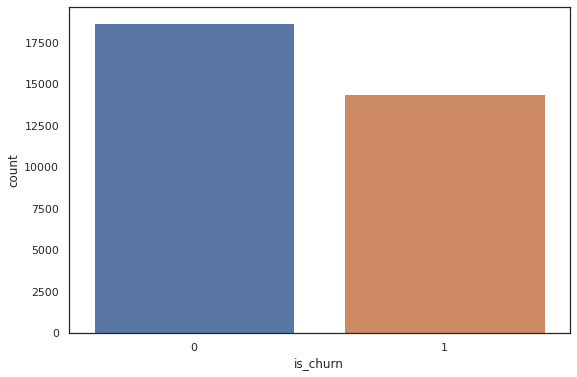

In [108]:
# Imbalance Data

# Observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(df_final.is_churn)

#The imbalanced data is solved by using stratified k-fold

<AxesSubplot:>

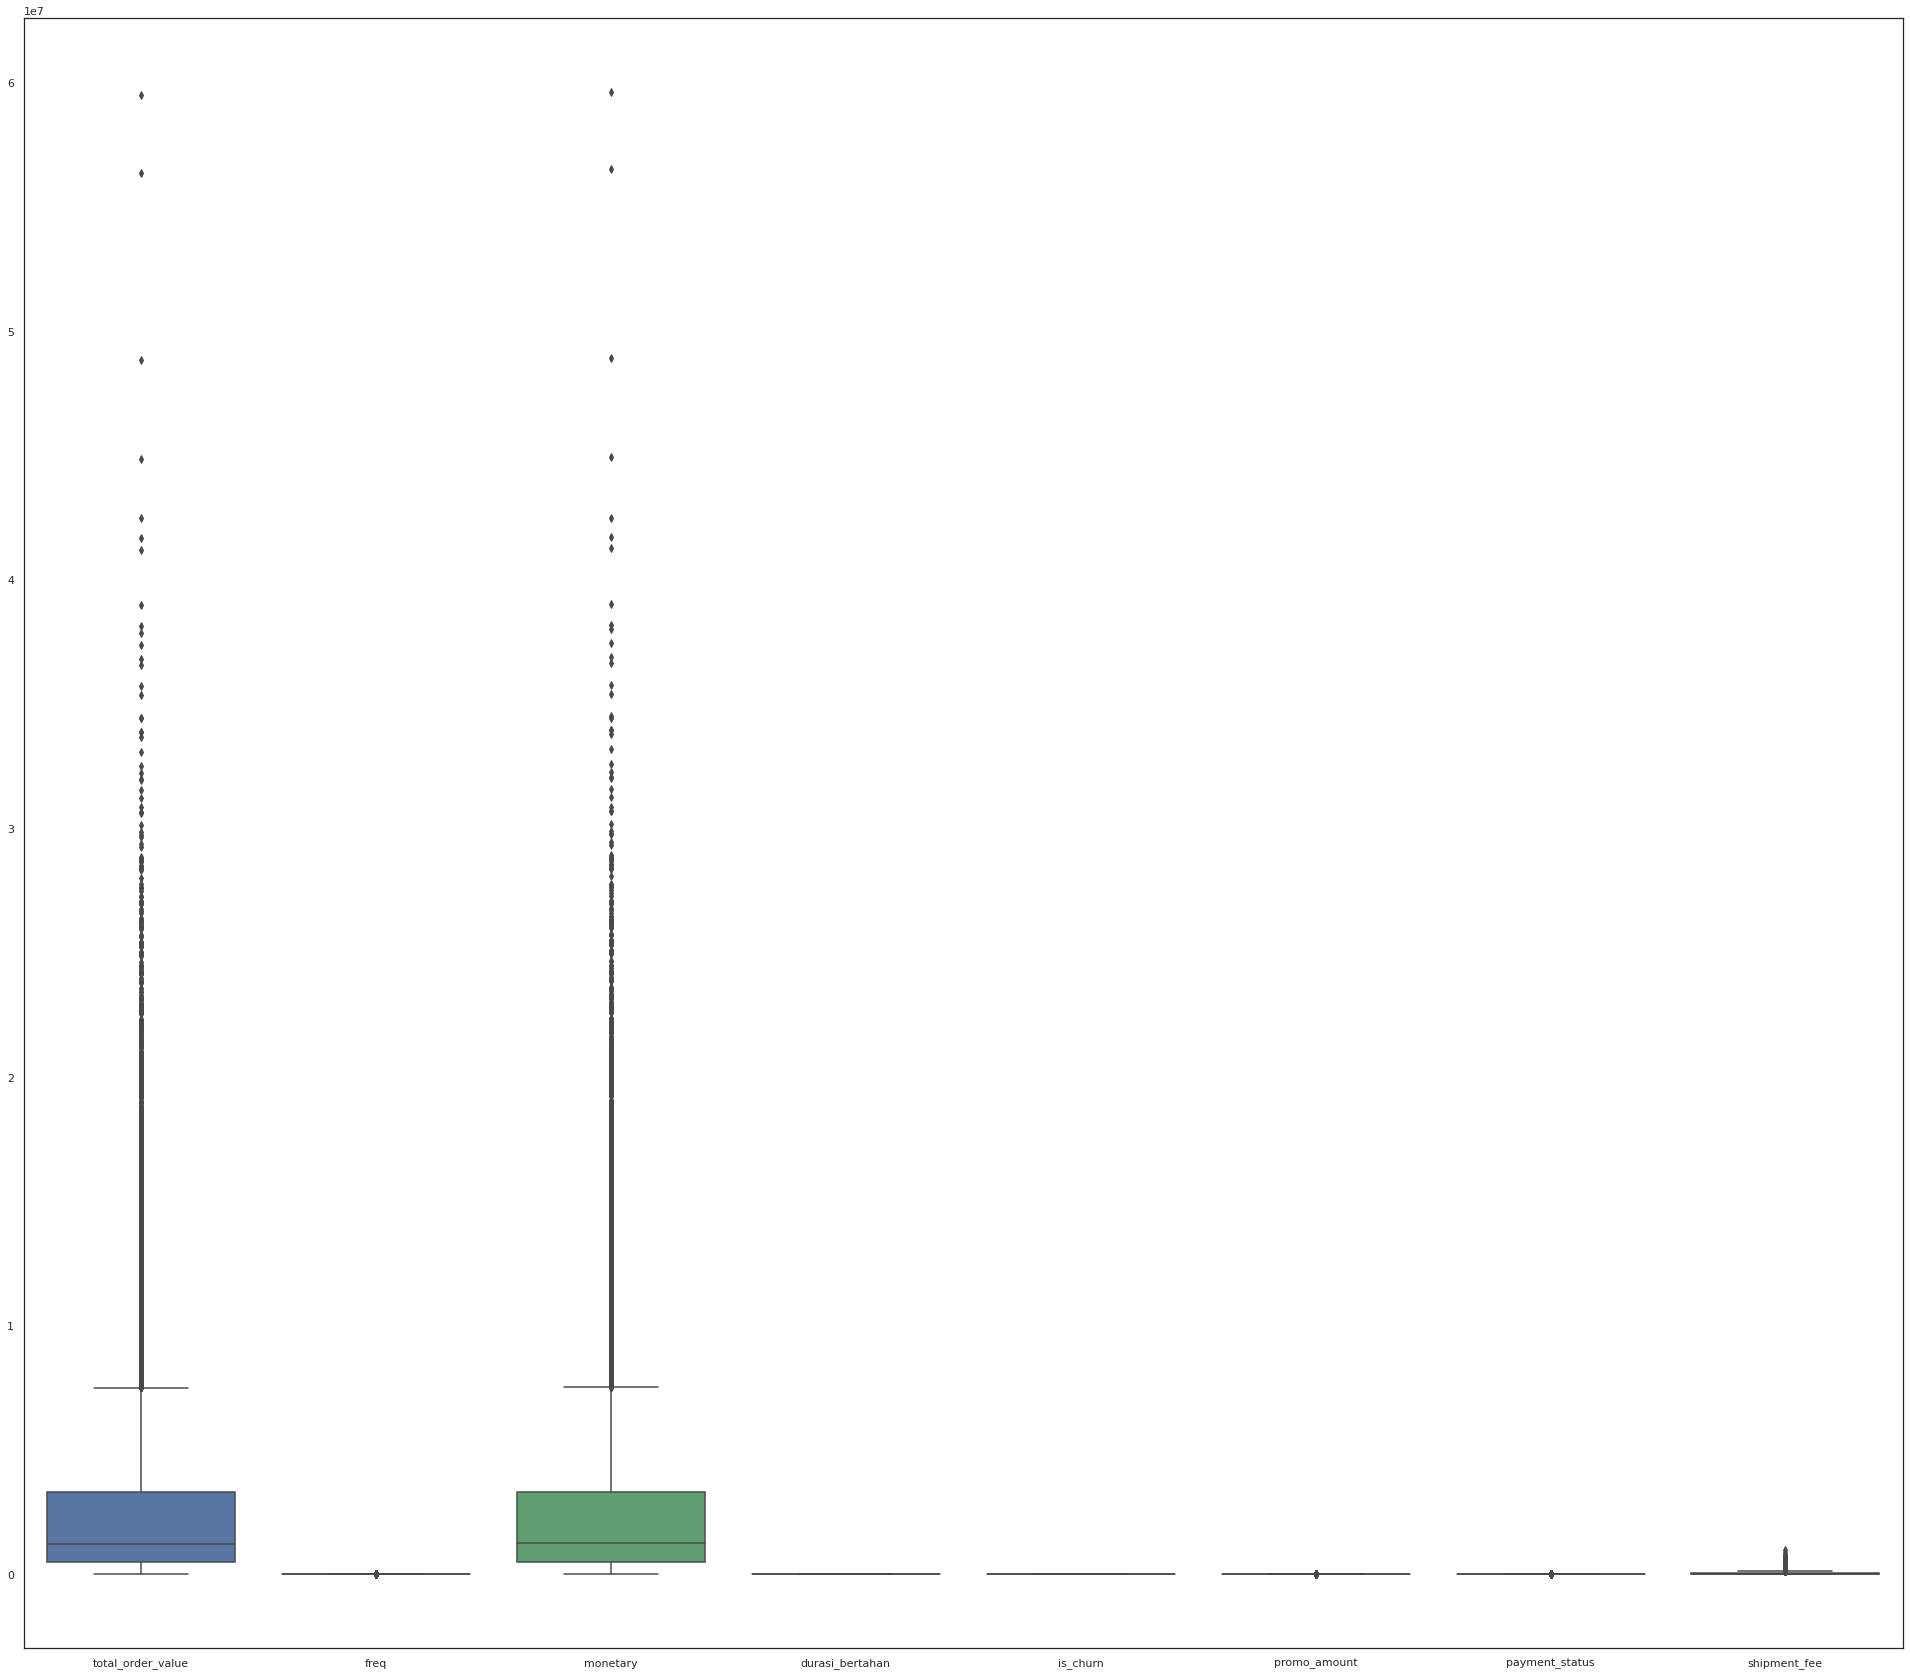

In [109]:
# Cek outlier Box Plot
fig, ax = plt.subplots(figsize=(30,30))
sns.boxplot(data=df_final)

In [110]:
# Z-Score
columns = list(df_final.columns.values)

for i in columns:
    upper_limit = df_final[i].mean() + 3*df_final[i].std()
    lower_limit = df_final[i].mean() - 3*df_final[i].std()

    df_final[i] = np.where(
        df_final[i]>upper_limit,
        upper_limit,
        np.where(
            df_final[i]<lower_limit,
            lower_limit,
            df_final[i]
        )
    )

<AxesSubplot:>

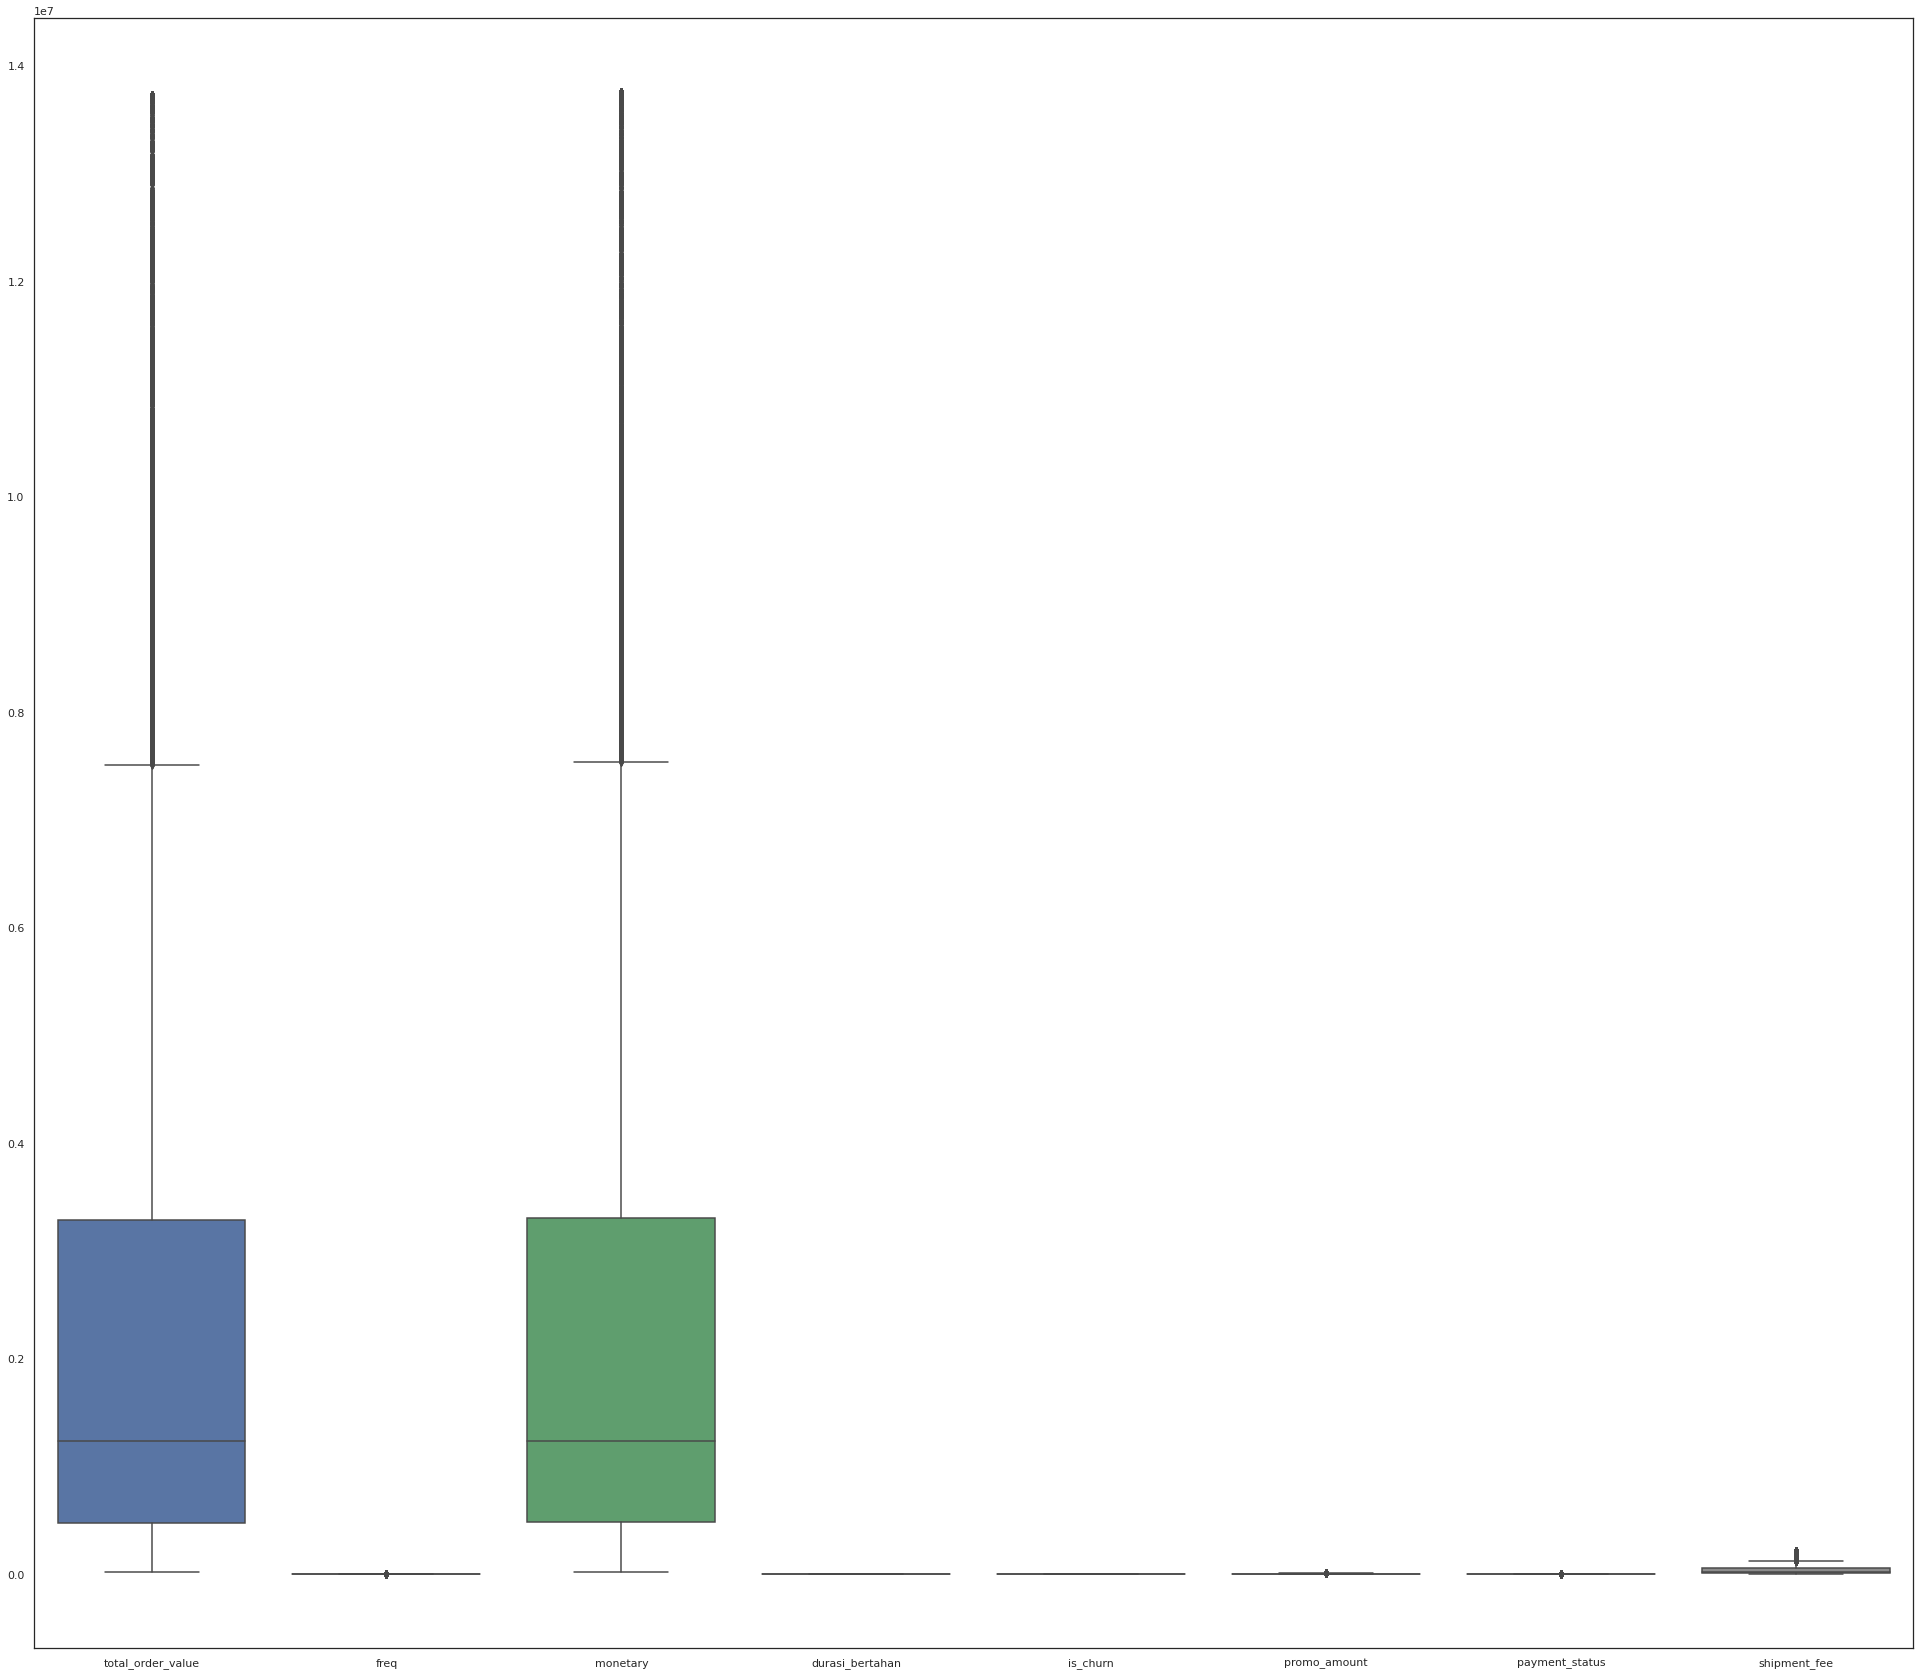

In [111]:
# Cek outlier Box Plot
fig, ax = plt.subplots(figsize=(30,30))
sns.boxplot(data=df_final)

<AxesSubplot:>

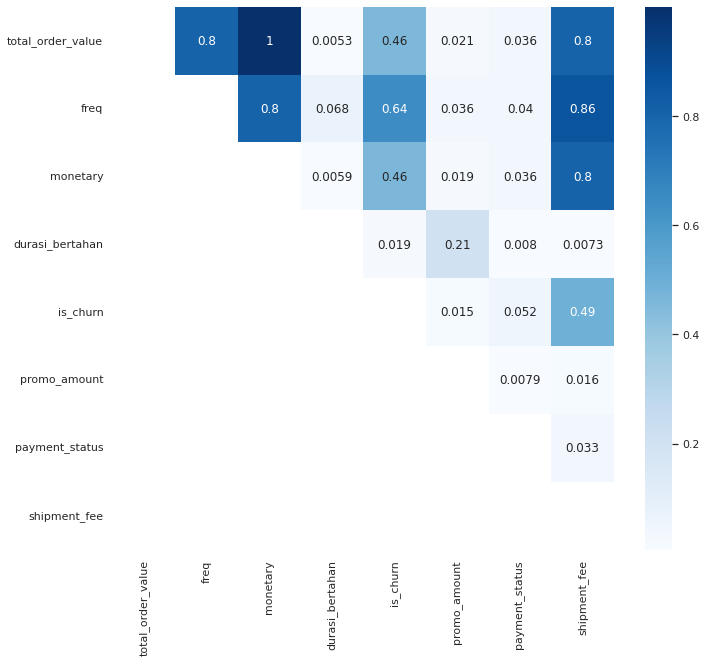

In [112]:
# Create correlation matrix
corr_matrix = df_final.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

plt.figure(figsize=(10,10))
sns.heatmap(upper, annot=True, cmap='Blues')

In [113]:
# error

In [114]:
df_final=df_final.drop(columns = ['shipment_fee','total_order_value','monetary'])

<AxesSubplot:>

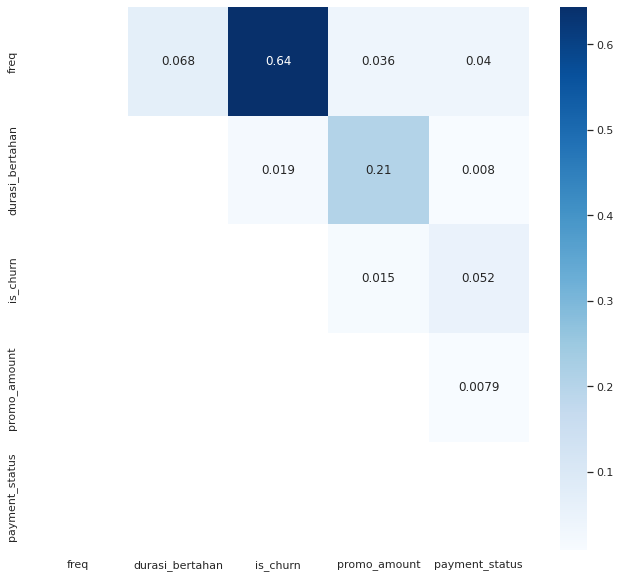

In [115]:
# Create correlation matrix
corr_matrix = df_final.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

plt.figure(figsize=(10,10))
sns.heatmap(upper, annot=True, cmap='Blues')

# Modelling

In [116]:
# Memisahkan mana X dan mana y
y= df_final['is_churn']
X= df_final.drop(['is_churn'],1)
X.head()

,freq,durasi_bertahan,promo_amount,payment_status
0,1.008952,1365.0,4541.000000,1.000000
1,2.070206,1366.0,1690.666667,0.916667
2,1.711117,1359.0,2756.166667,1.000000
3,0.067989,1292.0,2398.500000,1.000000
4,0.627414,1357.0,2073.000000,1.000000


In [117]:
y

0        0.0
1        0.0
2        0.0
3        1.0
4        0.0
        ... 
33142    1.0
33143    1.0
33144    0.0
33145    1.0
33146    1.0
Name: is_churn, Length: 33147, dtype: float64

In [118]:
#Machine learning Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [119]:
#Cross Validation -> Untuk menangani data yang tidak balance
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RepeatedStratifiedKFold

In [120]:
#Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix

In [121]:
# Modelling Algorithms

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

## Collect all model in one list
all_model = [
            DecisionTreeClassifier,
            LogisticRegression,
             KNeighborsClassifier,
             GaussianNB,
#             SVC,
            LinearSVC,
            RandomForestClassifier,
            GradientBoostingClassifier,
            ExtraTreesClassifier,
             XGBClassifier
            ]

model_name = [
        'DecisionTreeClassifier',
            'LogisticRegression',
             'KNeighborsClassifier',
             'GaussianNB',
#             'SVC',
            'LinearSVC',
            'RandomForestClassifier',
            'GradientBoostingClassifier',
            'ExtraTreesClassifier',
             'XGBClassifier'
             ]
## loop for all model

datatr = []
datasc = []
Recall =[]
Precision =[]
auc =[]

for idx, model_type in enumerate(all_model):
    num = 1
    AccTrain = []
    AccTest = []
    RecallTemp = []
    PrecisionTemp = []
    AucTemp = []
    nfold = 1
    for train_index,test_index in kf.split(X,y): 

        print("----------BEFORE------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        model = model_type()
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        AccTrain.append(model.score(X_train , y_train))
        AccTest.append(model.score(X_test , y_test))
        RecallTemp.append(recall_score(y_test,y_pred))
        PrecisionTemp.append(precision_score(y_test,y_pred))
        AucTemp.append(roc_auc_score(y_test, y_pred))
        
        print("----------AFTER------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        nfold += 1
    
    print("----------FINAL------------")
    print("{} Acc Train: {}".format(model_name[idx], np.mean(AccTrain)))
    print("{} Acc Test: {}".format(model_name[idx], np.mean(AccTest)))
    print("{} Recall: {}".format(model_name[idx], np.mean(RecallTemp)))
    print("{} Precission: {}".format(model_name[idx], np.mean(PrecisionTemp)))
    print("{} AUC: {}".format(model_name[idx], np.mean(AucTemp)))
    print("---------------------------")
    datatr.append(np.mean(AccTrain))
    datasc.append(np.mean(AccTest))
    Recall.append(np.mean(RecallTemp))
    Precision.append(np.mean(PrecisionTemp))
    auc.append(np.mean(AucTemp))

----------BEFORE------------
DecisionTreeClassifier Acc Train: [], 1 of KFold 5
DecisionTreeClassifier Acc Test: [], 1 of KFold 5
DecisionTreeClassifier Recall: [], 1 of KFold 5
DecisionTreeClassifier Precission: [], 1 of KFold 5
DecisionTreeClassifier AUC: [], 1 of KFold 5
---------------------------
----------AFTER------------
DecisionTreeClassifier Acc Train: [1.0], 1 of KFold 5
DecisionTreeClassifier Acc Test: [0.9895927601809955], 1 of KFold 5
DecisionTreeClassifier Recall: [0.9864818024263432], 1 of KFold 5
DecisionTreeClassifier Precission: [0.9895688456189151], 1 of KFold 5
DecisionTreeClassifier AUC: [0.989235560759233], 1 of KFold 5
---------------------------
----------BEFORE------------
DecisionTreeClassifier Acc Train: [1.0], 2 of KFold 5
DecisionTreeClassifier Acc Test: [0.9895927601809955], 2 of KFold 5
DecisionTreeClassifier Recall: [0.9864818024263432], 2 of KFold 5
DecisionTreeClassifier Precission: [0.9895688456189151], 2 of KFold 5
DecisionTreeClassifier AUC: [0.989

In [122]:
## compare model each other
data_hasil = pd.DataFrame()
data_hasil['model'] = model_name
data_hasil['Accuracy training'] = datatr
data_hasil['Accuracy test'] = datasc
data_hasil['Precision'] = Precision
data_hasil['Recall']= Recall
data_hasil['AUC']=auc
data_hasil['gap'] = abs(data_hasil['Accuracy training'] - data_hasil['Accuracy test'])
data_hasil.sort_values(by='Accuracy test',ascending=False)

,model,Accuracy training,Accuracy test,Precision,Recall,AUC,gap
8,XGBClassifier,0.999080,0.992880,0.995256,0.988354,0.992361,0.006200
0,DecisionTreeClassifier,1.000000,0.991583,0.991254,0.989393,0.991332,0.008417
5,RandomForestClassifier,0.999992,0.989713,0.994663,0.981629,0.988785,0.010280
6,GradientBoostingClassifier,0.988574,0.987209,0.997019,0.973518,0.985637,0.001365
7,ExtraTreesClassifier,1.000000,0.983830,0.987437,0.975251,0.982845,0.016170
1,LogisticRegression,0.972599,0.972456,0.966900,0.969913,0.972164,0.000143
3,GaussianNB,0.966943,0.967086,0.949392,0.976430,0.968158,0.000143
4,LinearSVC,0.899811,0.900078,0.940881,0.839376,0.893113,0.000267
2,KNeighborsClassifier,0.835340,0.761667,0.738798,0.699896,0.754578,0.073672


In [123]:
y.value_counts()

0.0    18722
1.0    14425
Name: is_churn, dtype: int64

In [124]:
import warnings
warnings.filterwarnings('ignore')

# Hyperparameter Tuning

In [125]:
#Grid Search
from sklearn.model_selection import GridSearchCV

In [126]:
#Grid Search RandomForestClassifier


model = RandomForestClassifier()

param = dict()
param['n_estimators']= [100]
param['criterion'] = ['entropy', 'gini']
param['bootstrap'] = [True, False]
param['max_depth'] = [6]
param['max_features'] = ['auto', 'sqrt']

cv = StratifiedKFold(n_splits=5)
clfRF = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clfRF.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'], 'max_depth': [6],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=4)

In [127]:
print('Best Score: {}'.format(clfRF.best_score_))
print('Best Hyperparameters: {}'.format(clfRF.best_params_))

Best Score: 0.9821404282613052
Best Hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}


In [128]:
#Grid Search GradientBoosting


model = GradientBoostingClassifier()

param = dict()
param['loss']= ["deviance"]
param['learning_rate'] = [0.025, 0.075, 0.2]
param['criterion'] = ["friedman_mse"]
param['max_depth'] = [3, 8]
param['n_estimators'] = [10]

cv = StratifiedKFold(n_splits=5)
clfGB = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clfGB.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.025, 0.075, 0.2],
                         'loss': ['deviance'], 'max_depth': [3, 8],
                         'n_estimators': [10]},
             scoring='accuracy', verbose=4)

In [129]:
print('Best Score: {}'.format(clfGB.best_score_))
print('Best Hyperparameters: {}'.format(clfGB.best_params_))

Best Score: 0.9896522683478395
Best Hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}


In [130]:
#Grid Search XGBClassifier


model = XGBClassifier()

param = dict()
param['min_child_weight']= [1, 10]
param['gamma'] = [1, 2]
# param['subsample'] = [0.6, 1.0]
# param['colsample_bytree'] = [0.3, 1.0]
param['max_depth'] = [4, 5]

cv = StratifiedKFold(n_splits=5)
clfXGB = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clfXGB.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interacti...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                

In [131]:
print('Best Score: {}'.format(clfXGB.best_score_))
print('Best Hyperparameters: {}'.format(clfXGB.best_params_))

Best Score: 0.9908892163802407
Best Hyperparameters: {'gamma': 1, 'max_depth': 5, 'min_child_weight': 1}


In [132]:
#Train-Test Split
from sklearn.model_selection import train_test_split

In [133]:
#Pisahin X, y jadi X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train dataset shape: ", X_train.shape)
print("y_train dataset shape: ", y_train.shape)
print("X_test dataset shape: ", X_test.shape)
print("y_test dataset shape: ", y_test.shape)

X_train dataset shape:  (26517, 4)
y_train dataset shape:  (26517,)
X_test dataset shape:  (6630, 4)
y_test dataset shape:  (6630,)


In [134]:
# Buat Model Pakai Best Param Dari GridSearchCV
modeltun = XGBClassifier(**clfXGB.best_params_)

In [135]:
# Melatih Model Pakai data train kita
model_fit = modeltun.fit(X_train,y_train)

In [136]:
# Cek Peforma model kita di data latih
y_pred_train=model_fit.predict(X_train)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14981
         1.0       1.00      0.99      1.00     11536

    accuracy                           1.00     26517
   macro avg       1.00      1.00      1.00     26517
weighted avg       1.00      1.00      1.00     26517



In [137]:
# Cek Peforma model kita di data test
y_pred_test=model_fit.predict(X_test)
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3741
         1.0       1.00      0.99      0.99      2889

    accuracy                           0.99      6630
   macro avg       0.99      0.99      0.99      6630
weighted avg       0.99      0.99      0.99      6630



# Feature Importance

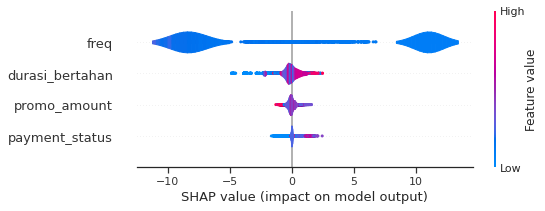

In [138]:
import shap

shap_values = shap.TreeExplainer(model_fit).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="violin")

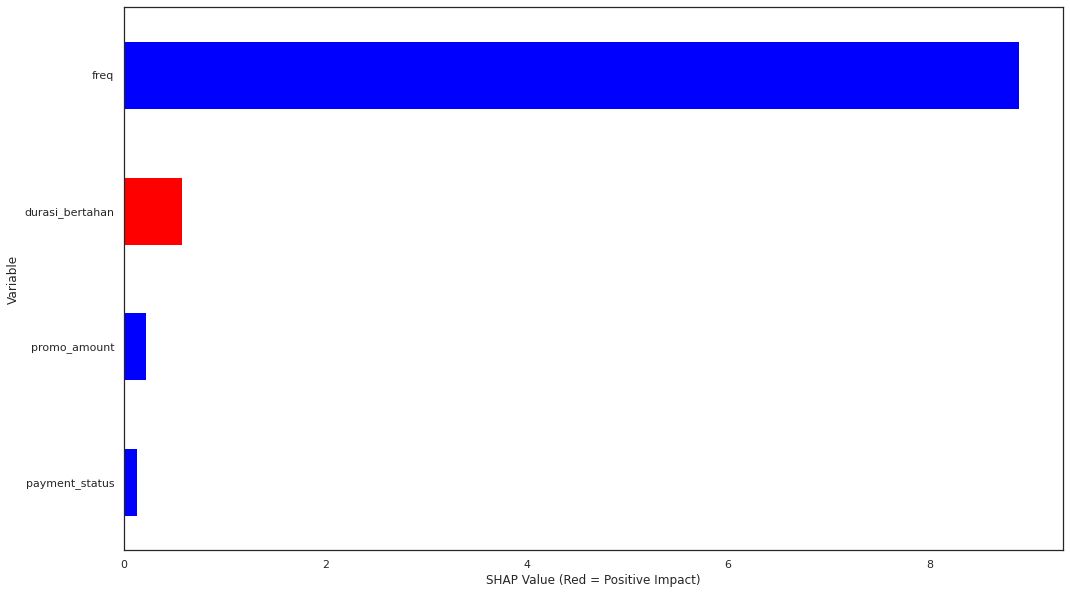

In [139]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',figsize=(15, 10),color = colorlist,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

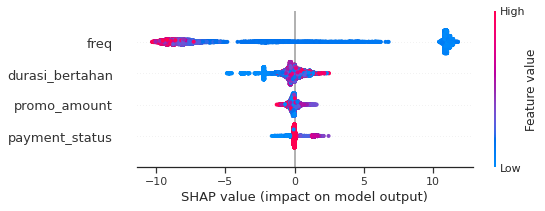

In [140]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)
#f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

Berdasarkan karakteristik diatas maka
1. Semakin tinggi nilai `freq` semakin rendah churn rate
2. Semakin tinggi nilai `monetary` semakin tinggi churn rate
3. Semakin tinggi nilai `durasi_bertahan` semakin rendah churn rate
4. Semakin tinggi nilai `total_order_value` semakin tinggi churn rate
5. Semakin tinggi nilai `payment_status` semakin rendah churn rate
6. Semakin tinggi nilai `promo_amount` semakin tinggi churn rate

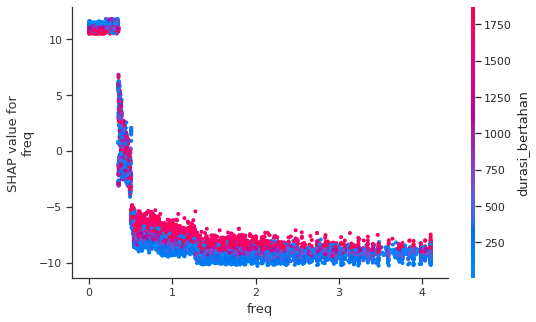

In [141]:
shap.dependence_plot('freq', shap_values, X_train)

In [142]:
shap.dependence_plot('monetary', shap_values, X_train)

ValueError: Could not find feature named: monetary

In [ ]:
shap.dependence_plot('durasi_bertahan', shap_values, X_train)

In [ ]:
shap.dependence_plot('payment_status', shap_values, X_train)

In [ ]:
shap.dependence_plot('promo_amount', shap_values, X_train)

[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.975 total time=   2.8s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.980 total time=   2.7s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.985 total time=   2.9s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.985 total time=   2.7s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.977 total time=   2.7s
[CV 1/5] END bootstrap=False, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.979 total time=   3.8s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.984 total time=   3.6s
[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=